# 파이트리 (Pytrees) 사용하기

<a href="https://colab.research.google.com/drive/1iYLSQalLqC0KuRPqCNwGj_O9aKwgMWGz" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

*저자: Vladimir Mikulik* <br/>
*번역: 장혜선*

배열의 딕셔너리, 딕셔너리 리스트로 이루어진 리스트, 또는 다른 중첩 구조의 객체와 작업하고자 하는 경우가 있습니다. JAX에서는 이러한 것들을 '파이트리(pytrees)' 라고 부르지만 가끔은 '네스트(nests)' 또는 '트리(trees)'라고 부르기도 합니다.

JAX는 라이브러리 함수뿐만 아니라 [`jax.tree_utils`](https://jax.readthedocs.io/en/latest/jax.tree_util.html) (대부분 `jax.tree_*`로 사용 가능)의 함수를 사용하여 이러한 객체에 대한 지원 기능이 내장되어 있습니다. 이번 섹션에서는 이 기능들의 사용 방법과 도움이 될만한 스니펫(snippet) 및 흔히 저지르는 실수(gotchas)에 대해 알아보겠습니다.

## 파이트리(Pytree) 란?

[JAX pytree docs](https://jax.readthedocs.io/en/latest/pytrees.html)의 정의는 다음과 같습니다.
> 파이트리(pytree)란 리프(leaf) 요소 및/또는 여러 개의 파이트리(pytrees)로 구성된 컨테이너입니다. 컨테이너에는 리스트, 튜플 및 딕셔너리가 포함됩니다. 리프(leaf) 요소는 파이트리(pytree)가 아닌 모든 것(예를 들면, 배열) 입니다. 즉, 파이트리(pytree)는 중첩될 가능성이 있는 표준 또는 사용자 등록 파이썬 컨테이너일 뿐입니다. 중첩된 경우, 컨테이너 유형이 일치할 필요는 없습니다. 단일 "리프"("leaf"), 즉, 컨테이너가 아닌 객체, 역시 파이트리(pytree)로 간주됩니다.

파이트리(Pytrees) 예제는 다음과 같습니다.

In [ ]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7f8c0dceee30>]   has 3 leaves: [1, 'a', <object object at 0x7f8c0dceee30>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


또한 트리(trees)의 리브스(leaves)를 나열하게 해준 `jax.tree_*` 함수를 처음 소개했습니다.

## 왜 파이트리(Pytrees)를 사용하나요?

머신러닝에서 파이트리(Pytrees)가 자주 사용되는 부분은 다음과 같습니다.

* 모델 매개 변수
* 데이터셋 항목
* 강화학습 에이전트의 관측치

또한 데이터셋을 대량으로 사용할 때 자연스럽게 발생하는 경우가 많습니다. (예를들면, 딕셔너리 리스트로 이루어진 리스트)

## 일반적인 파이트리(pytree) 함수

아마 가장 일반적으로 사용되는 파이트리(pytree) 함수는 `jax.tree_map` 입니다. 이것은 파이썬의 기본 `map`과 유사하며 파이트리(pytrees) 전체에 다음과 같이 작동합니다.

In [ ]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

`jax.tree_map`은 여러 인수를 넣어도 동작합니다.

In [ ]:
another_list_of_lists = list_of_lists
jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

`jax.tree_map`을 여러 인수와 사용할 때는 입력 인수 간 구조가 정확히 일치해야 합니다. 즉, 리스트는 동일한 수의 요소가 있어야하고 딕셔너리는 동일한 키가 있어야 합니다.

## 예제: 머신러닝 모델 매개 변수

간단한 다층 퍼셉트론(multi-layer perceptron, MLP) 학습 예제를 통해 파이트리(pytree) 연산이 유용한 몇 가지 방법을 볼 수 있습니다.

In [ ]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

`jax.tree_map`을 사용하여 매개 변수의 크기가 예상과 같은지 확인할 수 있습니다.

In [ ]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

이제 다층 퍼셉트론(multi-layer perceptron, MLP)을 학습시켜 봅시다.

In [ ]:
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

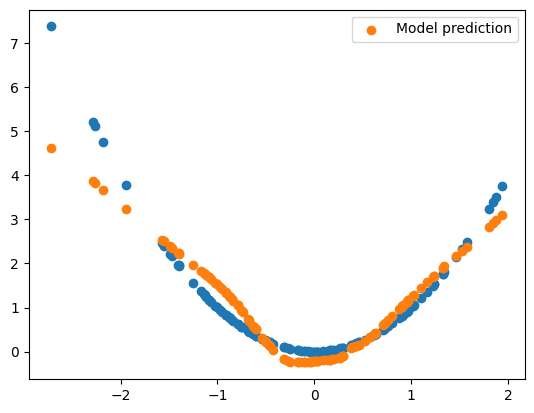

In [ ]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

## 사용자 정의 파이트리(pytree) 노드

지금까지는 리스트, 튜플, 딕셔너리의 파이트리(pytrees)만 생각했습니다. 다른 모든 것은 리프(leaf)로 간주하였습니다. 따라서 자신만의 컨테이너 클래스를 정의하면, 그 내부에 트리(trees)가 있더라도 리프(leaf)로 간주됩니다.

In [ ]:
class MyContainer:
  """A named container."""

  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

In [ ]:
jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

따라서, 리브스(leaves)를 컨테이너 내부 요소로 간주하고 트리 맵(tree map)을 사용한다면 오류가 발생합니다.

In [ ]:
jax.tree_map(lambda x: x + 1, [
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'

이를 해결하려면 JAX에 컨테이너를 등록하여 요소를 추출하여 나열(flatten)하거나 원복(unflatten)할 수 있는 방법을 알려야합니다.

In [ ]:
from typing import Tuple, Iterable

def flatten_MyContainer(container) -> Tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""
  flat_contents = [container.a, container.b, container.c]

  # we don't want the name to appear as a child, so it is auxiliary data.
  # auxiliary data is usually a description of the structure of a node,
  # e.g., the keys of a dict -- anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)

jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

최신 파이썬에는 컨테이너를 더 쉽게 정의할 수 있는 도구가 탑재되어 있습ㄴ다. 이 중 일부는 JAX에서 바로 작동하지만, 다른 것은 더 많은 주의가 필요합니다. 예를 들면,

In [ ]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# Since `tuple` is already registered with JAX, and NamedTuple is a subclass,
# this will work out-of-the-box:
jax.tree_util.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

이제 `name` 필드가 리프(leaf)로 표시되는 것을 알 수 있습니다. 이는 모든 튜플 요소가 자식이기 때문입니다. 클래스를 어렵게 등록하지 않아도 되는 것의 대가입니다.

## 흔한 파이트리(pytree) 실수와 패턴

### 실수들
#### 노드를 리브스(leaves)로 오인하는 실수

주의해야 할 흔한 문제 중 하나는 트리(tree) 노드를 리프(leaf)로 오인하는 것입니다.

In [ ]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, a_tree)
jax.tree_map(jnp.ones, shapes)

[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)),
 (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]

여기서 발생한 문제는, `shape` 배열이 튜플이기 때문에 파이트리(pytree) 노드로 취급되며, 그 원소는 리프(leaf)라는 것입니다. 따라서 map에서 jnp.ones가 `(2, 3)`에 호출되지 않고, `2`와 `3`에 대해 호출되고 있습니다.

해결책은 상황에 따라 달라질 수 있지만, 광범위하게 적용 가능한 두 가지의 옵션들이 있습니다.

* 사이에 들어가는 `tree_map`을 피하기 위해 코드를 재작성합니다.
* 튜플을 `np.array` 또는 `jnp.array`로 변환하여, 전체 시퀀스를 리프(leaf)로 만듭니다.

#### `None` 처리

`jax.tree_utils` 는 `None` 을 리프(leaf)가 아닌 자식이 없는 노드로 간주합니다.

In [ ]:
jax.tree_util.tree_leaves([None, None, None])

[]

### 패턴
#### 트리(trees) 전치

파이트리(pytree)를 전치하고 싶다면, 예를 들어 트리(trees)로 구성된 리스트에서 리스트로 구성된 트리(trees)로 바꾸고 싶다면, `jax.tree_map`을 사용하면 됩니다.

In [ ]:
def tree_transpose(list_of_trees):
  """Convert a list of trees of identical structure into a single tree of lists."""
  return jax.tree_map(lambda *xs: list(xs), *list_of_trees)


# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

더 복잡한 전치가 필요한 경우, JAX는 `jax.tree_transpose`를 제공합니다. 이는 설정할 것이 더 많지만 파이트리(Pytree) 내외부 구조를 지정할 수 있어 더 유연하게 사용할 수 있습니다.

In [ ]:
jax.tree_transpose(
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
  inner_treedef = jax.tree_structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

/tmp/ipykernel_722054/112383129.py:2: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
/tmp/ipykernel_722054/112383129.py:3: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  inner_treedef = jax.tree_structure(episode_steps[0]),
/tmp/ipykernel_722054/112383129.py:1: FutureWarning: jax.tree_transpose is deprecated, and will be removed in a future release. Use jax.tree_util.tree_transpose instead.
  jax.tree_transpose(


{'obs': [3, 4], 't': [1, 2]}

## 추가 정보

JAX의 파이트리(Pytree)와 사용 가능한 연산에 대한 자세한 내용은 공식 JAX 문서의 [Pytrees](https://jax.readthedocs.io/en/latest/pytrees.html) 섹션을 참조하세요.